# Transforming coordinates from crs to crs

> history \| Create July 2023 \| Updated August 2023<br/>

<a href="https://polarwatch.noaa.gov/" target="_blank">NOAA PolarWatch</a> distributes gridded and tabular oceanographic data for polar regions.  Satellite data include geospatial information and most of them are in geographical coordinates (latitude and longitude).  Since the spatial coverage of many PolarWatch satellite data products, are within polar regions, the geospatial information is often represented in polar projected coordinates. (<a href="https://nsidc.org/data/user-resources/help-center/guide-nsidcs-polar-stereographic-projection" target="_blank">Polar Stereographic Projections</a>).  

When working with multiple satellite data sets from different crs coordinates, it makes it challenging to do data analysis and the coordinate transformation may be needed. 

In this exercise, we will learn to transform coordinates of one projection to another.

**The exercise demonstrates the following techniques:**
-   Downloading and saving a netcdf file from PolarWatch ERDDAP data server
-   Accessing satellite data and metadata in polar stereographic projection 
-   Transforming coordinates using EPSG codes
-   Mapping data using the transformed coordinates

**Datasets used:**
    
   *Sea Ice Concentration*, NOAA/NSIDC Climate Data Record V4, Southern Hemisphere, 25km, Science Quality, 1978-2022, Monthly

**Python packages used:**
-   urllib3 (getting data from internet resources)
-   xarray (reading and analyzing data)
-   pyproj (crs and reprojection)
-   cartopy (mapping projection)
-   matplotlib (mapping)
-   import cmocean
-   numpy (data computation, data analysis, manipulation)



## Antarctic Sea Ice Concentration Data

The sea ice concentration data are used to calculate the spatical coverage of sea ice.  The data product in this exercise is sea ice concentration data of the southern hemisphere, and is produced by the NOAA/NSIDC from passive microwave sensors using the Climate Data Record (CDR).  The data are projected in the southern polarstereographic projection (**EPSG:3031**). 

This sea ice concentration data values in the dataset are represented as proportions ranging from 0 to 1. The resolution is 25km, meaning each grid in this data set represents a value that covers a 25km by 25km area.  Please note that other values beyond 1 represents fill values.  More detailed information can be found in the NSIDC Data Product User Guide (linke below)

**Userful links**

-   <a href="https://polarwatch.noaa.gov/catalog/ice-sq-nh-nsidc-cdr-v4/preview/?dataset=daily&var=cdr_seaice_conc&time_min=2022-05-31T00:00:00Z&time_max=2022-05-31T00:00:00Z&proj=epsg3413&colorBar=KT_ice|||0|1|" target="_blank">NOAA PolarWatch Data Product Page (download, preview)</a>
-   <a href="https://nsidc.org/data/g02202/versions/4" target="_blank">NSIDC Data Product Description</a>
-   <a href="https://nsidc.org/sites/default/files/g02202-v004-userguide_1_1.pdf" target="_blank">NSIDC Data Product User Guide (pdf)</a>






## Import  packages

In [12]:
import cartopy.crs as ccrs
import urllib.request
import pyproj
import xarray as xr
import numpy as np
from pyproj import CRS
from pyproj import Transformer
from matplotlib import pyplot as plt 
import cmocean

 ## Get data from ERDDAP

In [13]:
# request datafrom polarwatch.noaa.gov errdap and save it to sic.nc file

url="https://polarwatch.noaa.gov/erddap/griddap/nsidcG02202v4shmday.nc?cdr_seaice_conc_monthly[(2022-12-01T00:00:00Z):1:(2022-12-01T00:00:00Z)][(4350000.0):1:(-3950000.0)][(-3950000.0):1:(3950000.0)]"
urllib.request.urlretrieve(url, "sic.nc")

('sic.nc', <http.client.HTTPMessage at 0x13f360a90>)

In [14]:
# open and assign data from the file to a variable ds using xarray
ds = xr.open_dataset("sic.nc")

In [15]:
# view metadata 
ds

<xarray.Dataset>
Dimensions:                  (time: 1, ygrid: 332, xgrid: 316)
Coordinates:
  * time                     (time) datetime64[ns] 2022-12-01
  * ygrid                    (ygrid) float32 4.338e+06 4.312e+06 ... -3.938e+06
  * xgrid                    (xgrid) float32 -3.938e+06 -3.912e+06 ... 3.938e+06
Data variables:
    cdr_seaice_conc_monthly  (time, ygrid, xgrid) float32 ...
Attributes: (12/65)
    acknowledgement:                                     This project was sup...
    cdm_data_type:                                       Grid
    cdr_variable:                                        cdr_seaice_conc_monthly
    contributor_name:                                    Walter N. Meier, Flo...
    contributor_role:                                    principal investigat...
    Conventions:                                         CF-1.6, ACDD-1.3, CO...
    ...                                                  ...
    summary:                                             This data set provid...
    time_coverage_duration:                              P1M
    time_coverage_end:                                   2022-12-01T00:00:00Z
    time_coverage_resolution:                            P1M
    time_coverage_start:                                 2022-12-01T00:00:00Z
    title:                                               Sea Ice Concentratio...

## Transforming from CRS to CRS

When transforming from one CRS to another, it is important to inspect CRS definitions and the transformation function for proper transformation.
We will transform from CRS EPSG: 3031 (NSIDC Polar Stereographic South) to EPSG: 4326 (geographic coordinate system)  . 

There are few ways to specify CRS as shown below.  For this exercise, we will use EPSG code.


```
crs = CRS.from_epsg(4326)
crs = CRS.from_string("EPSG:4326")
crs = CRS.from_proj4("+proj=latlon")
```



In [16]:
crs_4326 = CRS.from_epsg(4326)
crs_4326

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [17]:
crs_3031 = CRS.from_epsg(3031)
crs_3031

<Derived Projected CRS: EPSG:3031>
Name: WGS 84 / Antarctic Polar Stereographic
Axis Info [cartesian]:
- E[north]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Antarctica.
- bounds: (-180.0, -90.0, 180.0, -60.0)
Coordinate Operation:
- name: Antarctic Polar Stereographic
- method: Polar Stereographic (variant B)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

## Inspect CRS definitions

**crs_4326**
* order of axis: latitude first, and longitude in degree
* bounds (-180, -90, 180, 90) global coverage  

**crs_3031**
* order of axis: X then Y in meter 
* bounds (-180, -90, 180, -60)

**based on the crs definitions**
* transformation input should be in the order of latitude and longitude
* transformation input/output should be within the bounds


*NOTE: if you prefer to use lon and lat (or x, y) axis order, you can set transformer parameter **always_xy** to True*

```Transformer.from_crs(crs_3031, crs_4326, always_xy=True)```

In [18]:
# transformer converts lon and lat values to x, y 

transformer = Transformer.from_crs(crs_3031, crs_4326)

In [19]:
# create a retangular grid 
x, y = np.meshgrid(ds.xgrid, ds.ygrid)

# pass x and y grid values to transform
lat, lon = transformer.transform(x,y)

## Add latitude and longitude values to the dataset

For adding the new coordinates to the dataset, create a tuple with its dimension and values then add to the dataset.  

- create a tuple  ```(dimension, value)```
- add to the dataset (ds) ```ds.coord['name']=(dimension, value)```


In [20]:
ds.coords['lat'] = (ds.cdr_seaice_conc_monthly[0][:].dims, lat)
ds.coords['lon'] = (ds.cdr_seaice_conc_monthly[0][:].dims, lon)

ds['cdr_seaice_conc_monthly'] = ds['cdr_seaice_conc_monthly'].where(ds['cdr_seaice_conc_monthly'] <= 1, np.nan)

## Plot data with new coordinates on a gloal map

Because the data were in the polar stereographic projection, mapping the data onto a different projection (global map projection) below, doesn't make the data fit well on the map.  


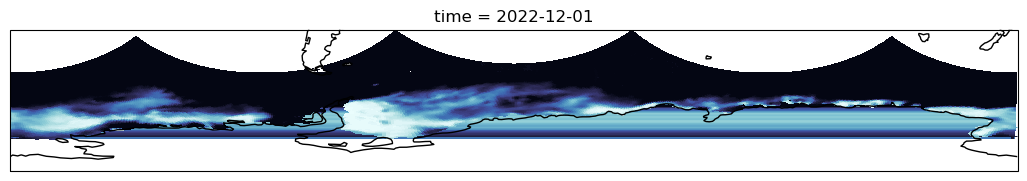

In [21]:
# set the map size
plt.figure(figsize=(13,5))
# set map projection (PlateCarree(): global map projection)
ax = plt.axes(projection=ccrs.PlateCarree())
# plot data with new coordinates
ds.cdr_seaice_conc_monthly[0][:].plot.pcolormesh('lon', 'lat', ax=ax, transform=ccrs.PlateCarree(), cmap=cmocean.cm.ice, add_colorbar=False)
# add coastlines to the map
ax.coastlines()

## Plot data with new coordinates on a projected map

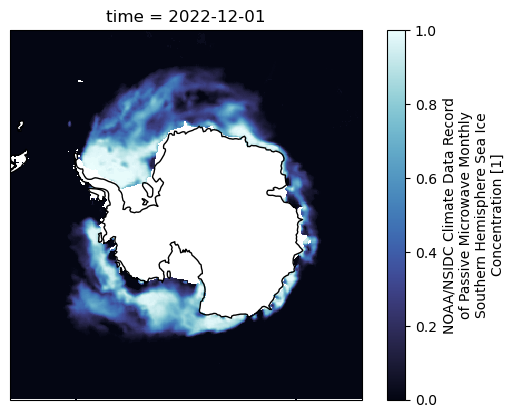

In [22]:
# set map projection (SouthPolarStereo(): southern polar steographic projection)
ax = plt.axes(projection=ccrs.SouthPolarStereo())
ds.cdr_seaice_conc_monthly[0][:].plot.pcolormesh('lon', 'lat', ax=ax, cmap=cmocean.cm.ice, transform=ccrs.PlateCarree())
ax.coastlines()